In [1]:
# Import des Librairies

import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
from numpy.random import multinomial
from scipy.special import digamma
from scipy.stats import dirichlet
import gensim.corpora as corpora
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pprint import pprint
import gensim
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
from sparsebm import generate_LBM_dataset, ModelSelection, LBM
from sparsebm.utils import reorder_rows, reorder_cols, ARI, CARI
from scipy.sparse import coo_matrix

In [2]:
# Stopwords : mots à ne pas considérer

stopwords = stopwords.words('english')
print(len(stopwords))
# stopwords in stopwords.txt
with open('stopwords-en.txt', 'r') as f:
    for line in f:
        stopwords.append(line.strip())
print(len(stopwords))

179
1477


In [3]:
# Load du dataframe des Reviews d'Amazon : formattage pour ressembler aux mieux au donnée du papier

df = pd.read_csv('Reviews.csv')
df.drop(['Id', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary'], axis=1, inplace=True)


prod = (df['ProductId'].value_counts() > 50)
prod = prod[prod].index.tolist()

user = (df['UserId'].value_counts() > 20)
user = user[user].index.tolist()

df = df[df['ProductId'].isin(prod)]
df = df[df['UserId'].isin(user)]


def remove_short_words(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) >= 3]
    return ' '.join(filtered_words)

def remove_punctuation_and_numbers(text):
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translator)


df['Text'] = df['Text']\
        .apply(lambda x: x.lower())\
        .apply(remove_punctuation_and_numbers)\
        .apply(remove_short_words)\
        .apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))\
        .apply(lambda x: x.split(' '))


# remove the words that appeared less than 10 times

from collections import Counter

words = Counter()

for idx in df.index:
    words.update(df.loc[idx, 'Text'])

words = {k:v for k, v in words.items() if v >= 10}

df['Text'] = df['Text'].apply(lambda x: [word for word in x if word in words])

df.drop_duplicates(subset=['UserId', 'ProductId'], inplace=True)

In [4]:
# Creation ofof the A-matrix with 1 where there is a connection between a product and a user, 0 otherwise

A = pd.DataFrame(np.zeros((len(df['ProductId'].unique()), len(df['UserId'].unique()))))
A.index = df['ProductId'].unique()
A.columns = df['UserId'].unique()

for idx in df.index:
    A.loc[df.loc[idx, 'ProductId'], df.loc[idx, 'UserId']] = 1

In [5]:
# Déclaration des constantes

V = len(words) # vocabulary size
K = 12 # number of topics
Q = 12 # cluster row
L = 14 # cluster column
D=np.ones(A.shape) # for amazon dataset, D is a matrix of ones

alphas = np.ones(K)

In [6]:
# Wordcloud pour visualisation (enregistrement sous 'wordcloud.png')

a = df['Text'].apply(lambda x: ' '.join(x))# Import the wordcloud library
# Join the different processed titles together.
long_string = ','.join(a)

wordcloud = WordCloud(width= 1000, height = 600, max_words=100,
                      random_state=1, background_color='gray', colormap='viridis_r',
                      collocations=False).generate(long_string)

wordcloud.to_file('wordcloud.png')

/Users/samy/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


In [7]:
# Create Dictionary for the future lda 
id2word = corpora.Dictionary(df['Text'])
# Create Corpus
texts = df['Text']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [8]:
# number of topics
num_topics = K
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.017*"taste" + 0.015*"tea" + 0.013*"coffee" + 0.011*"chocolate" + '
  '0.008*"water" + 0.007*"bars" + 0.006*"price" + 0.006*"flavor" + 0.006*"bar" '
  '+ 0.006*"organic"'),
 (1,
  '0.015*"hair" + 0.013*"food" + 0.010*"flavor" + 0.009*"product" + '
  '0.009*"shampoo" + 0.008*"chicken" + 0.007*"tea" + 0.006*"drink" + '
  '0.006*"scalp" + 0.006*"cat"'),
 (2,
  '0.018*"tea" + 0.012*"coffee" + 0.011*"taste" + 0.010*"flavor" + 0.009*"cup" '
  '+ 0.007*"product" + 0.006*"day" + 0.006*"time" + 0.006*"dog" + '
  '0.006*"love"'),
 (3,
  '0.030*"tea" + 0.020*"taste" + 0.016*"water" + 0.015*"coffee" + '
  '0.013*"flavor" + 0.010*"drink" + 0.009*"product" + 0.008*"sugar" + '
  '0.007*"cup" + 0.007*"love"'),
 (4,
  '0.018*"chips" + 0.014*"flavor" + 0.012*"taste" + 0.011*"coffee" + '
  '0.008*"product" + 0.006*"cookies" + 0.006*"water" + 0.006*"sweet" + '
  '0.005*"bag" + 0.005*"bit"'),
 (5,
  '0.014*"food" + 0.014*"dog" + 0.011*"product" + 0.010*"coffee" + 0.010*"cat" '
  '+ 0.009*"drink" +

In [9]:
x=lda_model.show_topics(num_words=13)

twords={}
for topic,word in x:
    twords[topic]=re.sub('[^A-Za-z ]+', '', word)

In [10]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.031136 -0.034344       1        1  13.916166
8     -0.024940 -0.026884       2        1  13.302594
4     -0.016548  0.044718       3        1   9.974367
7     -0.040931 -0.028267       4        1   9.255286
5      0.055958 -0.008224       5        1   8.707491
10     0.048065  0.034257       6        1   8.113793
11     0.004560 -0.003487       7        1   7.865927
9     -0.012098  0.039885       8        1   7.645733
1      0.064765 -0.035200       9        1   7.135178
2     -0.000851 -0.022857      10        1   4.934233
6      0.011401  0.025397      11        1   4.808998
0     -0.058244  0.015006      12        1   4.340233, topic_info=         Term          Freq         Total Category  logprob  loglift
602    coffee  19632.000000  19632.000000  Default  30.0000  30.0000
0       chips   7097.000000   7097.000000  Default  29.0000  29.0000
537       tea  16808.000000  16808.000000  Default  28.0000  28.0000
501       dog   5798.000000   5798.000000  Default  27.0000  27.0000
2006     hair   2795.000000   2795.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
27       size    154.563955   2497.227439  Topic12  -5.8785   0.3549
476   product    202.465508   9262.729777  Topic12  -5.6086  -0.6859
411     drink    174.686434   7145.219062  Topic12  -5.7561  -0.5740
23        bit    165.242911   4847.367496  Topic12  -5.8117  -0.2415
53      enjoy    155.975625   2875.723041  Topic12  -5.8694   0.2229

[965 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
991       6  0.734483  acknowledge
451       1  0.176293          add
451       2  0.075296          add
451       3  0.087966          add
451       4  0.145524          add
...     ...       ...          ...
2969      5  0.097717        zukes
2969      6  0.062818        zukes
2969      7  0.146576        zukes
2969      9  0.160536        zukes
2969     11  0.446708        zukes

[4345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 5, 8, 6, 11, 12, 10, 2, 3, 7, 1])

In [11]:
# Initialisation du premier LBM pour la clusterisation initial

lbm_model_selection = LBM(
    Q,
    L,
    n_init_total_run=1
)

lbm_models = lbm_model_selection.fit(np.matrix(A))

---------- START RANDOM INITIALIZATIONS ---------- 
100 of 100 Initializations:  [100% ] |#############| [ Elapsed Time: 0:00:25 ] 
----- CONTINUE TRAINING FOR THE BEST INITIALIZATIONS ----- 
1 of 1 Runs:  [100% ] |############################| [ Elapsed Time: 0:00:00 ] 


Text(0.5, 1.0, 'Reordered Matrix')

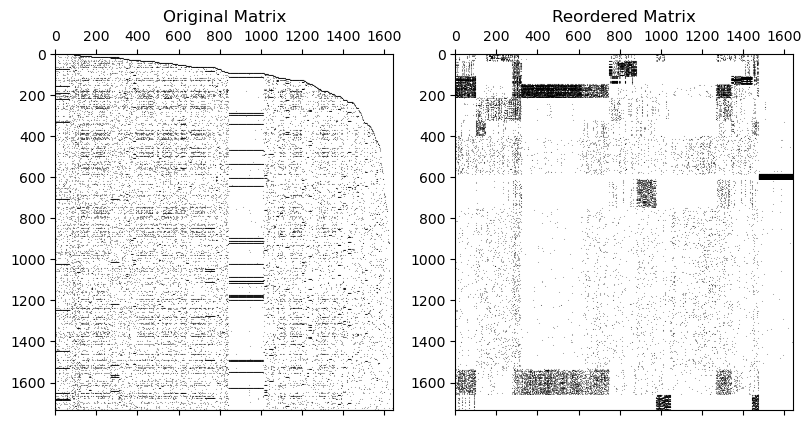

In [12]:
# Reordonnement des lignes et colonnes en fonction du clustering des indiv et variables (sans le texte)

reconstructed_matrix = coo_matrix(np.matrix(A).copy())
reorder_rows(reconstructed_matrix, np.argsort(lbm_models.row_labels))
reorder_cols(reconstructed_matrix, np.argsort(lbm_models.column_labels))

# Create the plot
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

# Plotting the original matrix

ax1.spy(A, markersize=0.05, marker="*", c="black")
ax1.set_title("Original Matrix")

ax2.spy(reconstructed_matrix, markersize=0.05, marker="*", c="black")
ax2.set_title("Reordered Matrix")

In [13]:
#  Définition de la matrice Y : Y is a matrix of size len(df['ProductId'].unique()) * Q) where the (i, j)th entry is 1 if the ith product belongs to the jth cluster
Y = np.zeros((len(df['ProductId'].unique()), Q))
for i in range(len(df['ProductId'].unique())):
    for j in range(Q):
        if lbm_models.row_labels[i] == j:
            Y[i, j] = 1

# Définition de la matrice X : X is a matrix of size len(df['UserId'].unique()) * L) where the (i, j)th entry is 1 if the ith user belongs to the jth cluster
X = np.zeros((len(df['UserId'].unique()), L))
for i in range(len(df['UserId'].unique())):
    for j in range(L):
        if lbm_models.column_labels[i] == j:
            X[i, j] = 1

In [14]:
# A_full : Copy the DataFrame A avec plus d'informations
A_full = A.copy()

# The last column is the cluster of the individual users
A_full['cluster_row'] = lbm_models.row_labels.tolist()

# # The last row is the cluster of the individual products
A_full.loc[len(A_full)] = lbm_models.column_labels.tolist() + [np.nan]
A_full.index = list(A_full.index[:-1]) + ['cluster_column']

In [15]:
# N is the matrix where the (i, j)th entry is the len of the Text of the ith user for the jth product
# Create mappings for UserId and ProductId to contiguous indices
user_id_mapping = {user_id: idx for idx, user_id in enumerate(df['UserId'].unique())}
product_id_mapping = {product_id: idx for idx, product_id in enumerate(df['ProductId'].unique())}

# Initialize the matrix N
N = np.zeros((len(user_id_mapping), len(product_id_mapping)))

# Populate the matrix
for idx in df.index:
    user_idx = user_id_mapping[df.loc[idx, 'UserId']]
    product_idx = product_id_mapping[df.loc[idx, 'ProductId']]
    N[user_idx, product_idx] = len(df.loc[idx, 'Text'])


In [22]:
load_A_full_topic = True

if load_A_full_topic:
    A_full_topic = pd.read_csv('A_full_topic.csv')

else:

    A_full_topic = A_full.copy()

    for i in A_full_topic.index[:-1]:
        for j in A_full_topic.columns[:-1]:
            if A_full_topic.loc[i, j] == 1:
                txt = df.loc[(df['UserId'] == j) & (df['ProductId'] == i), 'Text']
                txt = txt.values[0]
                topic = lda_model.get_document_topics(id2word.doc2bow(txt))[0][0]
            else:
                topic = -1
            A_full_topic.loc[i, j] = str(topic)

    # Save the matrix A_full_topic because it takes a long time to compute
    A_full_topic.to_csv('A_full_topic.csv')

# 4m20 to run if load_A_full_topic = False

In [19]:
# Theta_ql is the topic proportion of the lth cluster of the qth row

# Initialize Theta_ql
Theta_ql = np.zeros((Q, L, K))

# Populate Theta_ql
for i in A_full_topic.index[:-1]:
    for j in A_full_topic.columns[:-1]:   
        if A_full_topic.loc[i, j] != '-1':
            Theta_ql[int(A_full_topic.loc[i, 'cluster_row']), int(A_full_topic.loc['cluster_column', j]), int(A_full_topic.loc[i, j])] += 1  

# Normalize Theta_ql
for q in range(Q):
    for l in range(L):
        if np.sum(Theta_ql[q, l, :]) != 0:
            Theta_ql[q, l, :] /= np.sum(Theta_ql[q, l, :])

In [46]:
def get_topic_n_word(i,j,n):
    txt = df.loc[(df['UserId'] == j) & (df['ProductId'] == i), 'Text']
    txt = txt.values[0][n]
    id_word = id2word.token2id[txt]
    topic = lda_model.get_term_topics(id_word)
    try:
        max_topic = max(topic, key=lambda x: x[1])
        max_topic = max_topic[0]
    except:
        max_topic = np.random.randint(0, K) # if the word is not in the vocabulary, we assign it to a random topic
    return max_topic



# p(Aij = 1 | XiqYjl=1) = PIql^Aij * (1 - PIql)^(1 - Aij)

def p_Aij_XY(Aij, PIql):
    prob = PIql**Aij * (1 - PIql)**(1 - Aij)
    return prob

# p(A | Y, X, PI) = prod_{i, j} p(Aij | Yi, Xj, PI)

def p_A_YX(A, Y, X, PI):
    prob = 1
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for q in range(Y.shape[1]):
                for l in range(X.shape[1]):
                    prob *= p_Aij_XY(A.iloc[i, j], PI.iloc[q, l])**(Y.iloc[i, q] * X.iloc[j, l])
    return prob


def phi_ijdnk(i, j, d, n, k, w, gamma, Y, X):
    first_prod = 1
    second_prod = 1
    for v in range(V):
        first_prod*=beta_kv(k, v, A, w, D, N, w, gamma, Y, X)**w[i, j, d, n, v]
    for q in range(Q):
        for l in range(L):
            second_prod *= np.exp(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))**(Y[i, q]*X[j, l])
    return first_prod*second_prod


def gamma_qlk(q, l, k, alpha, A, Y, X, D, N, b, w, gamma):
    res = alpha[k]
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    res += A[i][j]*Y[i, q]*X[j, l]*phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)
    return res

def beta_kv(k, v, A, W, D, N, w, gamma, Y, X):
    res=0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    res+=A[i][j]*W[i][j][d][n][v]*phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)

def pi_ql(q, l, A, Y, X):  # GOOD
    res=0
    A = A.reset_index(drop=True)
    A.columns = range(A.shape[1])
    shape_A = A.shape
    A = np.matrix(A)
    for i in range(shape_A[0]):
        for j in range(shape_A[1]):
            res+=Y[i, q]*X[j, l]*A[i,j]
    return res


def p_q(q, Y):  # GOOD
    return np.sum(Y[:,q])

def s(l, X): # GOOD
    return np.sum(X[:,l])

def q_theta(theta, Q, L, alpha, A, Y, X, D, N, b, w, gamma):
    prod=1
    for q in range(Q):
        for l in range(L):
            gammas = [gamma_qlk(q, l, k, alpha, A, Y, X, D, N, b, w, gamma) for k in range(K)]
            prod*=dirichlet.pdf(theta[q, l], alpha=gammas)   
    return prod

def q_z(z, i, j, d, n, b, w, gamma, Y, X):
    phi = [phi_ijdnk(i, j, d, n, k, b, w, gamma, Y, X) for k in range(K)]
    return multinomial.pdf(z[i][j][d][n], n=1, p=phi)

def greedy_serch(Y, X):
    for i in range(A.shape[0]):
        q = np.where(Y[i]==1)[0][0]
        friends = False
        for i_prime in range(A.shape[0]):

            if Y[i_prime, q] == 1 and i_prime != i:
                friends = True
                break
        if friends:
            Final_Clust = q
            bestGain = 0
            for q_prime in range(Q):
                if q_prime != q:
                    Y[i, q] = 0
                    Y[i, q_prime] = 1
                    gain = compute_gain(Y, X, D, N, A, w, gamma, Q, L, K)
                    if gain > bestGain:
                        bestGain = gain
                        Final_Clust = q_prime
            Y[i, q] = 0
            Y[i, Final_Clust] = 1

    for j in range(A.shape[1]):
        l = X[j].idxmax()
        friends = False
        for j_prime in range(A.shape[1]) and j_prime != j:
            if X[j_prime, l] == 1:
                friends = True
                break
        if friends:
            Final_Clust = l
            bestGain = 0
            for l_prime in range(L):
                if l_prime != l:
                    X[j, l] = 0
                    X[j, l_prime] = 1
                    gain = compute_gain(Y, X, D, N, A, w, gamma, Q, L, K)
                    if gain > bestGain:
                        bestGain = gain
                        Final_Clust = l_prime
            X[j, l] = 0
            X[j, Final_Clust] = 1
    return Y, X

def compute_gain(Y, X, D, N, A, w, gamma, Q, L, K):
    gain1 = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a = A[i, j]
            subres = 0
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for q in range(Q):
                        for l in range(L):
                            subsubres = 0
                            for k in range(K):
                                subsubres += phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)*(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))
                            subres += X[j, l]*subsubres
            gain1 += a*subres
    gain2 = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a = A[i, j]
            subres = 0
            for d in range(D[i][j]):
                for n in range(N[i][j][d]):
                    for q in range(Q):
                        for l in range(L):
                            subsubres = 0
                            for k in range(K):
                                subsubres += phi_ijdnk(i, j, d, n, k, w, gamma, Y, X)*(digamma(gamma[q][l][k]) - digamma(sum(gamma[q][l])))
                            subres += Y[i,q]*subsubres
            gain2 += a*subres

    return gain1 + gain2
# b not defined

In [47]:
max_iter = 10
i=0
while i<max_iter:
    Y, X = greedy_serch(Y, X)
    i+=1

NameError: name 'w' is not defined